In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 49 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 0s (22.3 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype

# RandomForest Classifier 모델 개발

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
import pandas as pd
import numpy as np
import math

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
train = pd.read_csv('/content/gdrive/MyDrive/신용카드 사용자/train.csv')
test = pd.read_csv('/content/gdrive/MyDrive/신용카드 사용자/test.csv')

test.head(3)

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month
0,26457,M,Y,N,0,112500.0,Pensioner,Secondary / secondary special,Civil marriage,House / apartment,-21990,365243,1,0,1,0,NaN,2.0,-60.0
1,26458,F,N,Y,0,135000.0,State servant,Higher education,Married,House / apartment,-18964,-8671,1,0,1,0,Core staff,2.0,-36.0
2,26459,F,N,Y,0,69372.0,Working,Secondary / secondary special,Married,House / apartment,-15887,-217,1,1,1,0,Laborers,2.0,-40.0


In [ ]:
train = pd.read_csv('/content/gdrive/MyDrive/신용카드 사용자/train.csv')
test = pd.read_csv('/content/gdrive/MyDrive/신용카드 사용자/test.csv')

In [ ]:
# 데이터 확인
display(train.head(2))
display(test.head(2))
print(train.shape, test.shape)

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
0,0,F,N,N,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,-13899,-4709,1,0,0,0,NaN,2.0,-6.0,1.0
1,1,F,N,Y,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-11380,-1540,1,0,0,1,Laborers,3.0,-5.0,1.0


,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month
0,26457,M,Y,N,0,112500.0,Pensioner,Secondary / secondary special,Civil marriage,House / apartment,-21990,365243,1,0,1,0,NaN,2.0,-60.0
1,26458,F,N,Y,0,135000.0,State servant,Higher education,Married,House / apartment,-18964,-8671,1,0,1,0,Core staff,2.0,-36.0


(26457, 20) (10000, 19)


# 모델 개발: 데이터 전처리

In [ ]:
# 불필요 컬럼 제거
train.drop(['index', 'FLAG_MOBIL'], axis=1, inplace=True)
test.drop(['index', 'FLAG_MOBIL'], axis=1, inplace=True)

In [ ]:
# 결측치 확인
print(train.isna().sum())

gender              0
car                 0
reality             0
child_num           0
income_total        0
income_type         0
edu_type            0
family_type         0
house_type          0
DAYS_BIRTH          0
DAYS_EMPLOYED       0
work_phone          0
phone               0
email               0
occyp_type       8171
family_size         0
begin_month         0
credit              0
dtype: int64


In [ ]:
print(train['occyp_type'].unique())
print(train['occyp_type'].nunique())
# NaN 데이터 제외하고 18개의 유니크 값 확인

[nan 'Laborers' 'Managers' 'Sales staff' 'High skill tech staff'
 'Core staff' 'Drivers' 'Medicine staff' 'Accountants' 'Realty agents'
 'Security staff' 'Cleaning staff' 'Private service staff' 'Cooking staff'
 'Secretaries' 'HR staff' 'IT staff' 'Low-skill Laborers'
 'Waiters/barmen staff']
18


In [ ]:
# 약 8000개의 결측치 어떻게 처리할지 고민하기
# [1] 신용 등급값이 뭔지 확인하고, 다른 특성들(나이, 차소유, 부동산소유, 가족수, 결혼유무 등)을 고려하여 일치하는 값 중 최빈값으로 매칭
train.groupby(['occyp_type','credit']).credit.count()


# [2] 예측 모델에 직종이 상위권에 있는 특성 중요도가 아니라면, 그냥 NaN을 별도 처리 없이 진행해본다. >>> 일단 이거 진행

occyp_type             credit
Accountants            0.0        118
                       1.0        227
                       2.0        557
Cleaning staff         0.0         40
                       1.0         93
                       2.0        270
Cooking staff          0.0         58
                       1.0        110
                       2.0        289
Core staff             0.0        347
                       1.0        622
                       2.0       1677
Drivers                0.0        187
                       1.0        358
                       2.0       1030
HR staff               0.0          7
                       1.0          4
                       2.0         51
High skill tech staff  0.0        123
                       1.0        270
                       2.0        647
IT staff               0.0          8
                       1.0         10
                       2.0         23
Laborers               0.0        586
                    

In [ ]:
# 중복 데이터 확인
print(train.duplicated().sum())


# 1634 개의 중복행 발견 >>> 왜?
# [가정1] 
# 하나의 카드회사 데이터가 아니라 여러 카드회사의 종합 데이터면 그럴 수 있음.
# 같은 고객이 다른 회사의 신용카드 이용객 정보에 들어가서 중복이 된 것.
# [가정1]의 경우 >>> 어차피 같은 사람의 데이터를 활용하는 것이므로 불필요한 데이터이므로 삭제 처리

# [가정2]
# 만약 한 회사의 신용카드 데이터일 경우 다른 고객 데이터이므로 삭제처리 진행해선 안됨.
# 우연히 모든 고객 정보가 일치하는 고객들이 중복 값을 일으킨 경우가 발생한 것. 
# [가정2]의 경우 중복 값 그대로 남겨둔 채 진행
# >>> [가정2]에서 의문점 발견
# 입력한 모든 정보가 일치하는 고객이 1634명이 될 가능성이 있는가? 중국 자료여서 가능성은 있다고 생각됨. 
# 만약 한국 데이터일 경우는 어떻게 처리하나?
# 진짜로 입력한 정보는 같은데 다른 고객인지 확인하는 작업이 필요. 주민등록번호/집주소/휴대폰 번호 등 개인 고유 정보를 활용을 통해 가능 

# 신용등급 컬럼을 제외하면, 2353개의 중복행이 늘어남 >>> 왜?
# [가정3]
# 여러 카드 회사 정보일 경우로 가정 (한 회사의 경우 시스템 문제로 보임 아니면 시점이 달라져 신용평가 기준이 달라졌을 경우를 고려 >>> 근데 그럼 이 데이터를 활용하는게 올바른진 모르겠음. 기준이 다 뒤섞인 데이터로 예측모델 개발하는건 바람직하지 않는 것으로 보임)
# 고객의 신용등급이 카드 회사마다 기준이 달라서 신용 등급만 다른 경우가 발생
# >>> 어느 등급의 데이터를 남겨야 할 지 고민하기
# 현재로선 신용우수 등급의 데이터가 부족해서 신용미흡 등급으로 표기된 데이터를 삭제하는 방향으로 진행
# 0이 있으면 0을 남기기, 0이 없고 1이 있으면 1남기기, 0과1 모두 없으면 2남기기 

# 가정3에 따라 진행 > 가정1의 경우도 함께 진행되므로 가정3으로 삭제처리 후 남은 중복데이터 삭제 진행(학습 시 똑같은 데이터 여러개 필요없음)


1634


In [ ]:
print('중복처리되기 전 shape:', train.shape)

중복처리되기 전 shape: (26457, 18)


중복값 처리

In [ ]:
def duplicate(df):
  condition1 = df.drop('credit', axis=1).duplicated(keep=False) # 신용등급 제외한 중복된 데이터 (더 많은 데이터 수 보유)
  duplicated_idx1 = condition1[condition1].index # 신용 등급 제외한 중복 데이터 리스트(인덱스)
  print(df.loc[duplicated_idx1].shape, '신용등급만 다를 수 있는 shape')
  duplicated_df_idx = df.loc[duplicated_idx1].index # 신용정보 없는 중복 데이터들 > 신용정보 필요함 > 인덱스화해서 df에 대입하기
  duplicated_df = df.loc[duplicated_df_idx].sort_values(by='credit') # 중복된 데이터들을 신용 0등급 > 1등급 > 2등급 순으로 배치 후 
  # 신용등급만 다를 수 있는 중복 데이터 추출 완료
  print(duplicated_df.shape, '신용등급만 다를 수 있는 shape') 
  duplicated_df.drop_duplicates(keep='first', inplace=True) # 중복된 데이터 삭제(0등급이 먼저 배치되어 있으므로 삭제되는건 0등급보다 뒤에 있는 값들임) 
  # 중복 데이터 중에 우수 등급의 고객들만 추출완료
  print(duplicated_df.shape, '신용 미흡한 중복값들 제거 된 후 shape') # >>> 제거 될 건 다 제거되고 남은 값들임

  df.drop(index=duplicated_idx1, inplace=True) # 기존 데이터에서의 (신용정보만 다른 값 포함한) 중복되는 모든 데이터 삭제
  print(df.shape, '원본데이터에서 중복되는 모든값 삭제한 shape')
  df = pd.concat([df, duplicated_df], axis=0, ignore_index=True) # 기존 데이터에 삭제된 우수 등급 고객들만 다시 추가
  print('---')
  print(df.shape, '최종적으로 중복값들 중에 우수 고객들과 다시 합친 최종 shape')
  return df


duplicated_train = duplicate(train) 
display(duplicated_train.head(3))

(4497, 18) 신용등급만 다를 수 있는 shape
(4497, 18) 신용등급만 다를 수 있는 shape
(2863, 18) 신용 미흡한 중복값들 제거 된 후 shape
(21960, 18) 원본데이터에서 중복되는 모든값 삭제한 shape
---
(24823, 18) 최종적으로 중복값들 중에 우수 고객들과 다시 합친 최종 shape


,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,work_phone,phone,email,occyp_type,family_size,begin_month,credit
0,F,N,N,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,-13899,-4709,0,0,0,NaN,2.0,-6.0,1.0
1,F,N,Y,0,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-15088,-2092,0,1,0,Sales staff,2.0,-37.0,0.0
2,F,Y,Y,0,157500.0,State servant,Higher education,Married,House / apartment,-15037,-2105,0,0,0,Managers,2.0,-26.0,2.0


In [ ]:
print('중복값 처리 개수:', 26457 - 24823)

중복값 처리 개수: 1634


결측치 처리

In [ ]:
def fillna(df):
  df['occyp_type'].fillna('NaN', inplace=True)
  return df

nan_prepro_train = fillna(duplicated_train)

데이터 전처리

In [ ]:
def gender(df): # F(여자):0 M(남자):1
  df['gender'] = df['gender'].replace(['F','M'], [0, 1])
  return df['gender']

def car(df): # N(차 없음):0 Y(차 있음):1
  df['car'] = df['car'].replace(['N','Y'], [0, 1])
  return df['car']

def reality(df): # N(부동산 없음):0 Y(부동산 있음):1
  df['reality'] = df['reality'].replace(['N','Y'], [0, 1])
  return df['reality']

def income_total(df):
  df['income_total'] = df['income_total'] / 10000
  return df['income_total'] # 소득액 10,000 단위로 환산

def income_type(df): # 소득 유형 >> ordinal-encoding 수행
  pass

def edu_type(df): #  'Lower secondary(초등)':1, 'Secondary / secondary special(중등)':2, 'Incomplete higher(고등 중퇴)':3, 'Higher education(고등)':4, 'Academic degree(대학)':5
  df['edu_type'] = df['edu_type'].replace(['Higher education', 'Secondary / secondary special', 'Incomplete higher', 'Lower secondary', 'Academic degree'], [4, 2, 3, 1 ,5])
  return df['edu_type']

def family_type(df): # 결혼 여부 >> ordinal-encoding 수행
  pass

def house_type(df): # 생활 형식 >> ordinal-encoding 수행
  pass

def occupa_type(df): # 직업 유형(직종) >> 결측치 'NaN'문자열로 대체
  pass  

# 데이터 수집 당시 (0)부터 역으로 셈, 즉, -1은 데이터 수집일 하루 전에 태어났음을 의미
def DAYS_BIRTH(df):
  df['DAYS_BIRTH'] = df['DAYS_BIRTH'].apply(abs) / 365
  df['DAYS_BIRTH'] = df['DAYS_BIRTH'].apply(round)
  df['DAYS_BIRTH'] = np.select([df['DAYS_BIRTH'] < 10, df['DAYS_BIRTH'] < 20, df['DAYS_BIRTH'] < 30, df['DAYS_BIRTH'] < 40, df['DAYS_BIRTH'] < 50, df['DAYS_BIRTH'] < 60, df['DAYS_BIRTH'] < 70, df['DAYS_BIRTH'] >= 70],
                                [0, 10, 20, 30, 40, 50, 60, 70])
  return df['DAYS_BIRTH'] # 나이는 연령대로 환산

# 데이터 수집 당시 (0)부터 역으로 셈, 즉, -1은 데이터 수집일 하루 전부터 일을 시작함을 의미. 양수 값은 고용되지 않은 상태를 의미함
def DAYS_EMPLOYED(df): 
  condition = (df['DAYS_EMPLOYED'] > 0)
  df.loc[condition, 'DAYS_EMPLOYED'] = 0
  df['DAYS_EMPLOYED'] = df['DAYS_EMPLOYED'].apply(abs) / 365
  df['DAYS_EMPLOYED'] = np.select([df['DAYS_EMPLOYED'] < 10, df['DAYS_EMPLOYED'] < 15, df['DAYS_EMPLOYED'] < 20, df['DAYS_EMPLOYED'] < 25, df['DAYS_EMPLOYED'] < 30, df['DAYS_EMPLOYED'] < 35, df['DAYS_EMPLOYED'] < 40, df['DAYS_EMPLOYED'] >= 40],
                                   [df['DAYS_EMPLOYED'], 10, 15, 20, 25, 30, 35, 40])
  df['DAYS_EMPLOYED'] = df['DAYS_EMPLOYED'].apply(round)
  return df['DAYS_EMPLOYED'] # 일 시작한지 '몇 년' 됐는지 리턴. 1년 단위로 계산 후 => 10년차 이후 부터 5년 단위로 갱신

# 데이터 수집 당시 (0)부터 역으로 셈, 즉, -1은 데이터 수집일 한 달 전에 신용카드를 발급함을 의미
def begin_month(df):
  df['begin_month'] = df['begin_month'].apply(abs) / 12
  df['begin_month'] = df['begin_month'].apply(round)
  return df['begin_month'] # 신용카드 발급한 지 '몇 년' 됐는지 리턴

def estimated_income(df): # 신용카드 이용자의 실제 소득 추정치(결혼유무와 가족 구성원 수 고려)
  df['estimated_income'] = np.select([(df['family_type'] == 'Civil marriage'), (df['family_type'] == 'Married')], 
                                     [df['income_total']/df['family_size'], df['income_total']/df['family_size']], 
                                      df['income_total'])
  return df['estimated_income'] 


nan_prepro_train['gender'] = gender(nan_prepro_train)
nan_prepro_train['car'] = car(nan_prepro_train)
nan_prepro_train['reality'] = reality(nan_prepro_train)
nan_prepro_train['income_total'] = income_total(nan_prepro_train)
nan_prepro_train['edu_type'] = edu_type(nan_prepro_train)
nan_prepro_train['DAYS_BIRTH'] = DAYS_BIRTH(nan_prepro_train)
nan_prepro_train['DAYS_EMPLOYED'] = DAYS_EMPLOYED(nan_prepro_train)
nan_prepro_train['begin_month'] = begin_month(nan_prepro_train)
nan_prepro_train['estimated_income']  = estimated_income(nan_prepro_train)

condition = nan_prepro_train['family_size'] < 6
condition_index = condition[condition].index
nan_prepro_train = nan_prepro_train.loc[condition_index]

prepro_train = nan_prepro_train
display(prepro_train.head(3))
print()
print(prepro_train.info())
print()
print(display(prepro_train.describe()))

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,work_phone,phone,email,occyp_type,family_size,begin_month,credit,estimated_income
0,0,0,0,0,20.25,Commercial associate,4,Married,Municipal apartment,30,10,0,0,0,NaN,2.0,0,1.0,10.125
1,0,0,1,0,20.25,Commercial associate,2,Married,House / apartment,40,6,0,1,0,Sales staff,2.0,3,0.0,10.125
2,0,1,1,0,15.75,State servant,4,Married,House / apartment,40,6,0,0,0,Managers,2.0,2,2.0,7.875



<class 'pandas.core.frame.DataFrame'>
Int64Index: 24766 entries, 0 to 24822
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            24766 non-null  int64  
 1   car               24766 non-null  int64  
 2   reality           24766 non-null  int64  
 3   child_num         24766 non-null  int64  
 4   income_total      24766 non-null  float64
 5   income_type       24766 non-null  object 
 6   edu_type          24766 non-null  int64  
 7   family_type       24766 non-null  object 
 8   house_type        24766 non-null  object 
 9   DAYS_BIRTH        24766 non-null  int64  
 10  DAYS_EMPLOYED     24766 non-null  int64  
 11  work_phone        24766 non-null  int64  
 12  phone             24766 non-null  int64  
 13  email             24766 non-null  int64  
 14  occyp_type        24766 non-null  object 
 15  family_size       24766 non-null  float64
 16  begin_month       24766 non-null  int64

,gender,car,reality,child_num,income_total,edu_type,DAYS_BIRTH,DAYS_EMPLOYED,work_phone,phone,email,family_size,begin_month,credit,estimated_income
count,24766.000000,24766.000000,24766.000000,24766.000000,24766.000000,24766.000000,24766.000000,24766.000000,24766.000000,24766.000000,24766.000000,24766.000000,24766.000000,24766.000000,24766.000000
mean,0.331382,0.378866,0.672777,0.420375,18.690070,2.573569,39.152467,5.612372,0.225269,0.294638,0.091739,2.187757,2.153840,1.514738,10.507214
std,0.470719,0.485115,0.469209,0.703844,10.093115,0.900668,12.072716,5.812824,0.417767,0.455889,0.288663,0.881763,1.432623,0.704407,7.806767
min,0.000000,0.000000,0.000000,0.000000,2.700000,1.000000,20.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.756000
25%,0.000000,0.000000,0.000000,0.000000,12.150000,2.000000,30.000000,1.000000,0.000000,0.000000,0.000000,2.000000,1.000000,1.000000,5.625000
50%,0.000000,0.000000,1.000000,0.000000,15.750000,2.000000,40.000000,4.000000,0.000000,0.000000,0.000000,2.000000,2.000000,2.000000,8.100000
75%,1.000000,1.000000,1.000000,1.000000,22.500000,4.000000,50.000000,9.000000,0.000000,1.000000,0.000000,3.000000,3.000000,2.000000,13.500000
max,1.000000,1.000000,1.000000,4.000000,157.500000,5.000000,60.000000,40.000000,1.000000,1.000000,1.000000,5.000000,5.000000,2.000000,157.500000


None


category


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


                  income_total  estimated_income
income_total           1.00000           0.71254
estimated_income       0.71254           1.00000


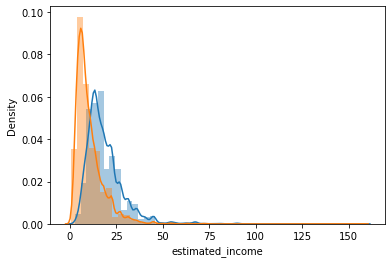

In [ ]:
# 'estimated_income'과 'income_total'
prepro_train['credit'] = prepro_train['credit'].astype('category')
print(prepro_train['credit'].dtype)
sns.distplot(prepro_train['income_total'], kde=True)
sns.distplot(prepro_train['estimated_income'], kde=True)

print(prepro_train[['income_total','estimated_income']].corr())
# 강한 양의 상관관계를 보이므로 기존의 'income_total' 제거
prepro_train.drop('income_total', axis=1, inplace=True)

In [ ]:
!pip install category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 69 kB 5.1 MB/s 


In [ ]:
# 데이터 전처리 작업 중에 남은 피처들 오디널 인코딩으로 진행
from category_encoders import OrdinalEncoder

encoder = OrdinalEncoder(
cols=['income_type','family_type','house_type','occyp_type'],
drop_invariant=True,
verbose=1
)

train_encoded = encoder.fit_transform(prepro_train)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
display(train_encoded)
train_encoded.info()

,gender,car,reality,child_num,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,work_phone,phone,email,occyp_type,family_size,begin_month,credit,estimated_income
0,0,0,0,0,1,4,1,1,30,10,0,0,0,1,2.0,0,1.0,10.125
1,0,0,1,0,1,2,1,2,40,6,0,1,0,2,2.0,3,0.0,10.125
2,0,1,1,0,2,4,1,2,40,6,0,0,0,3,2.0,2,2.0,7.875
3,0,0,1,2,3,2,1,2,30,10,0,0,1,4,4.0,2,1.0,6.750
4,0,0,0,0,3,2,2,2,40,5,0,0,1,5,1.0,3,2.0,31.500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24818,0,1,1,2,1,4,1,2,30,1,0,1,0,3,4.0,5,2.0,6.750
24819,0,0,0,1,3,4,1,2,40,1,0,1,0,2,3.0,1,2.0,5.250
24820,1,0,1,2,4,4,1,2,40,0,0,0,0,1,4.0,1,2.0,3.375
24821,0,0,1,2,3,4,1,2,30,15,0,1,0,5,4.0,5,2.0,5.625


<class 'pandas.core.frame.DataFrame'>
Int64Index: 24766 entries, 0 to 24822
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   gender            24766 non-null  int64   
 1   car               24766 non-null  int64   
 2   reality           24766 non-null  int64   
 3   child_num         24766 non-null  int64   
 4   income_type       24766 non-null  int64   
 5   edu_type          24766 non-null  int64   
 6   family_type       24766 non-null  int64   
 7   house_type        24766 non-null  int64   
 8   DAYS_BIRTH        24766 non-null  int64   
 9   DAYS_EMPLOYED     24766 non-null  int64   
 10  work_phone        24766 non-null  int64   
 11  phone             24766 non-null  int64   
 12  email             24766 non-null  int64   
 13  occyp_type        24766 non-null  int64   
 14  family_size       24766 non-null  float64 
 15  begin_month       24766 non-null  int64   
 16  credit            2476

# 모델 개발: 모델 설계

In [ ]:
# 모델 설계
from xgboost import XGBClassifier

xgbc = XGBClassifier(n_estimators=100, 
                     n_jobs=-1)

모델 개발: 모델 학습을 위한 데이터 분리

In [ ]:
X = train_encoded.drop('credit', axis=1)
y = train_encoded['credit']

print(X.shape, y.shape)

(24766, 17) (24766,)


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.2, random_state=2)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(19812, 17) (4954, 17) (19812,) (4954,)


모델 학습

In [ ]:
xgbc.fit(
        X_train, y_train, # 전처리된 데이터로 학습 시작 
        eval_metric='logloss'
        )  # 학습 완료

XGBClassifier(n_jobs=-1, objective='multi:softprob')

성능 확인

In [ ]:
train_pred = xgbc.predict(X)

from sklearn.metrics import accuracy_score, f1_score

print('train 데이터 예측 정확도:', xgbc.score(X_val, y_val))

train 데이터 예측 정확도: 0.6667339523617279


In [ ]:
pd.DataFrame(train_pred).value_counts()

2.0    21597
1.0     3163
0.0        6
dtype: int64

이 아래 쪽은 test데이터로 테스트 해보려고 작성한건데 하지 않아서 무시하셔도 됩니다

In [ ]:
test = pd.read_csv('/content/gdrive/MyDrive/신용카드 사용자/test.csv')
test.drop(['index', 'FLAG_MOBIL'], axis=1, inplace=True)

In [ ]:
# test data는 중복X 
# >>> 결측치, 그외 전처리 및 인코딩수행

nan_prepro_test = fillna(test) # 결측치 제거X > 'NaN'문자로 대체

# 그외 전처리
nan_prepro_test['gender'] = gender(nan_prepro_test)
nan_prepro_test['car'] = car(nan_prepro_test)
nan_prepro_test['reality'] = reality(nan_prepro_test)
nan_prepro_test['income_total'] = income_total(nan_prepro_test)
nan_prepro_test['edu_type'] = edu_type(nan_prepro_test)
nan_prepro_test['DAYS_BIRTH'] = DAYS_BIRTH(nan_prepro_test)
nan_prepro_test['DAYS_EMPLOYED'] = DAYS_EMPLOYED(nan_prepro_test)
nan_prepro_test['begin_month'] = begin_month(nan_prepro_test)
nan_prepro_test['estimated_income']  = estimated_income(nan_prepro_test)
prepro_test = nan_prepro_test

# 특성 간 상관관계 보이는 컬럼 제거
prepro_test.drop('income_total', axis=1, inplace=True)

# dtype = 'object' 인코딩
test_encoded = encoder.fit_transform(prepro_test)

In [ ]:
test_pred = xgbc.predict(test_encoded)
pd.DataFrame(test_pred).value_counts()

2.0    8784
1.0    1212
0.0       4
dtype: int64